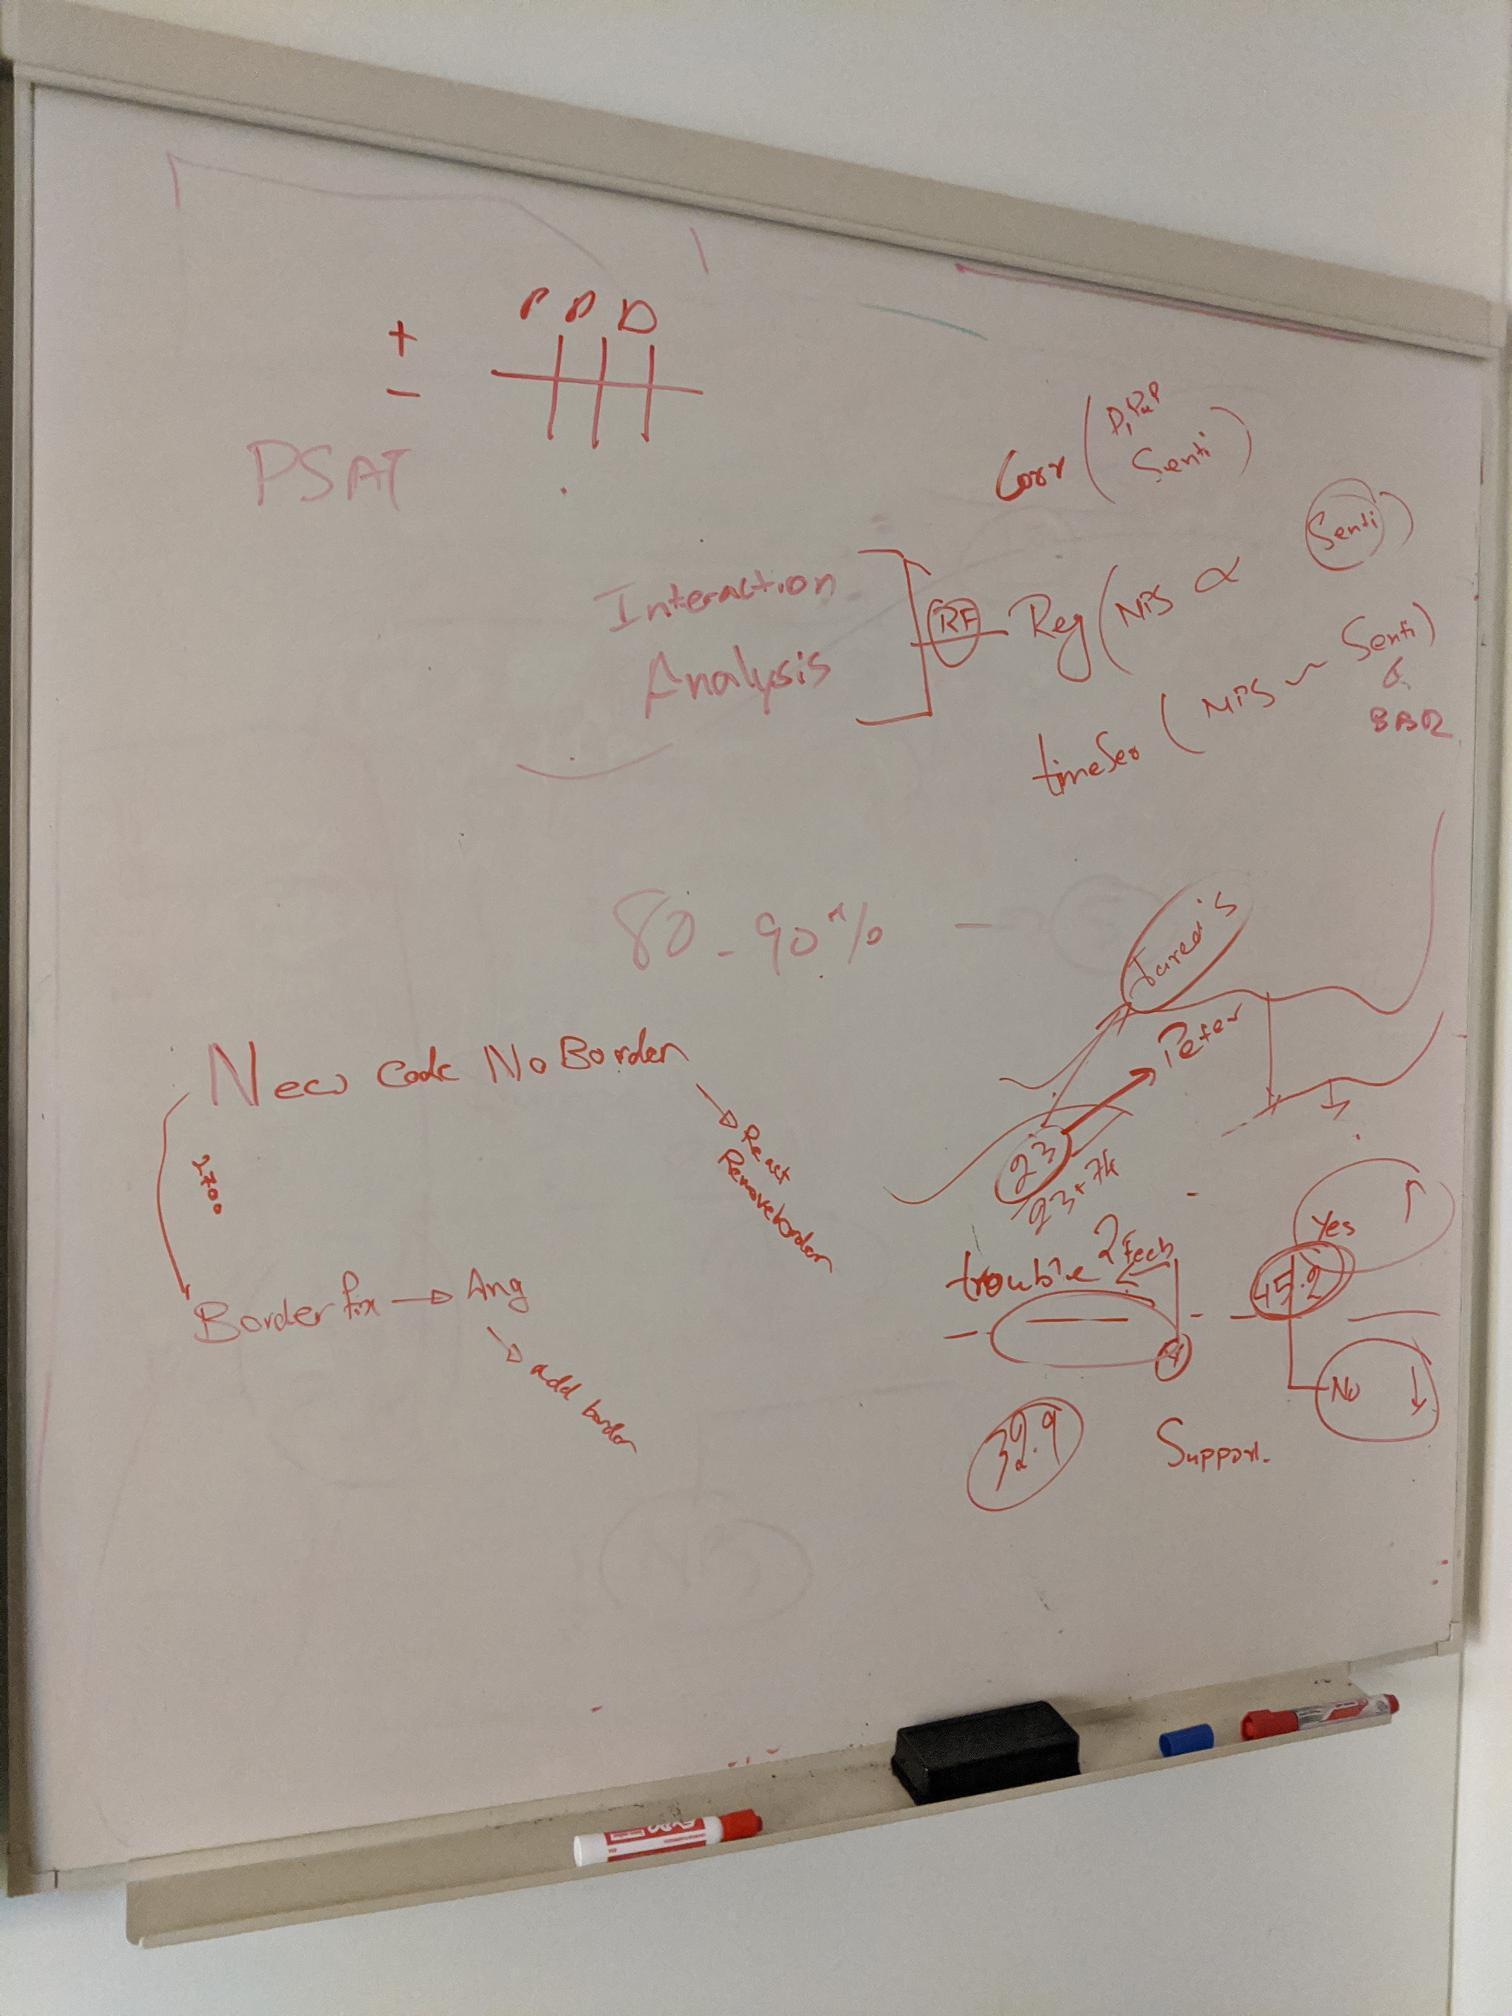

In [1]:
import os
import csv
import math
import pandas as pd
import numpy as np
import datetime
import xlwt
import glob
import pyexcel as p
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
import os

from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, OneClassSVM
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

import xgboost as xgb
import json

import matplotlib.pyplot as plt
%matplotlib inline


import scipy
from scipy import stats
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.graphics.tsaplots import plot_acf
import pandas_profiling

from IPython.display import Image
Image("MicrosoftTeams-image.png")

In [2]:
df = pd.read_csv('AdminSentimentData.csv',index_col='Feedback_ID') #From DataMart

In [3]:
df["Feedback_DateTime"] = df["Feedback_DateTime"].apply(lambda x: pd.to_datetime(x))
df['week_year'] = df.Feedback_DateTime.dt.to_period('W-SAT')

In [4]:
df['Feedback_DateTime'].min()

Timestamp('2018-07-01 00:53:37')

In [5]:
df_details = df[df.Verbatim_Details.notnull()]
Verbatim_Details = df_details.Verbatim_Details[df.Verbatim_Details.notnull()]
Verbatim_Dates = df_details.week_year[df.Verbatim_Details.notnull()]

In [6]:
DateTime_Dict = pd.to_datetime(df_details.Feedback_DateTime).to_dict()
Rating_Dict = df_details.Feedback_Rating.to_dict()
NPS_Dict = df_details.Feedback_RatingValue.to_dict()

In [7]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

# Verbatim Level

In [8]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [9]:
isfloat('')

False

In [10]:
details_dict = {}
for V, ix in zip(Verbatim_Details, Verbatim_Details.index):
    #Verbatim_Sample = Verbatim_Details.iloc[0]
    j = json.loads(V)
    sentiments = []

    for S in j:
        S = S.split(',')
        for AT in [item for item in S if item.find('SentimentClass')!=-1]:
            Class = find_between(S[-2].split(':')[1],'"','"')
            Prob = find_between(S[-1],":","}").strip().strip('"')
#             if isfloat(Prob):
#                 if (float(Prob)>0.25) & (float(Prob)<0.7):
#                     Class = 'Neutral'
                    #print(Class)
            #print(Class)
            sentiments.append(Class)
    details_dict[ix] = sentiments#','.join(list(set(themes)))

In [11]:
details = pd.Series(details_dict)
df_details['Sentences'] = df_details.index.map(details)
sentences = df_details[df_details.Sentences!='[]']['Sentences'].apply(pd.Series)
#faulty_jsonV = sentences[sentences[0]=='']
sentences = sentences[sentences[0]!='']
NSR_Dict = df_details.Feedback_RatingValue.to_dict()
Rating_Dict = df_details.Feedback_Rating.to_dict()
DateTime_Dict = pd.to_datetime(df_details.Feedback_DateTime).to_dict()

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
for col in sentences.columns:
    sentences.rename(columns={col:'Sentence '+str(col+1)},inplace=True)

Requested Metric: **NSR Per Verbatim**

In [13]:
nsr_per_verbatim = (sentences=='Negative').sum(axis=1)/(sentences.notnull()).sum(axis=1)

In [14]:
sentences['NSR_per_verbatim'] = nsr_per_verbatim

In [15]:
df_by_verbatim = df_details.join(sentences,how='inner')

In [16]:
df_by_verbatim.head(3)

,Feedback_DateTime,Feedback_Month,Feedback_Rating,Feedback_RatingValue,Feedback_Verbatim,Verbatim_Themes,Verbatim_Details,week_year,Sentences,Sentence 1,...,Sentence 14,Sentence 15,Sentence 16,Sentence 17,Sentence 18,Sentence 19,Sentence 20,Sentence 21,Sentence 22,NSR_per_verbatim
Feedback_ID,,,,,,,,,,,,,,,,,,,,,
f116af54-22c4-4315-9f17-d4f0b0766fee,2018-07-01 07:21:36,2018-07-31,3,-100,It is very good on laptops but all my employee...,"[""outlook""]","[""{\""FeedbackSentencesId\"": 545692,\""Sentence\...",2018-07-01/2018-07-07,"[Positive, Positive]",Positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
98d78aa6-b562-459b-a85a-e1598ad39f13,2018-07-01 11:53:12,2018-07-31,1,-100,Very difficult,"[""not mapped""]","[""{\""FeedbackSentencesId\"": 345492,\""Sentence\...",2018-07-01/2018-07-07,[Negative],Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
0be16e62-f736-47a6-b535-94e3a3b40a1b,2018-07-01 17:31:03,2018-07-31,5,100,MS 365 is a powerful and reasonably easy to us...,"[""not mapped""]","[""{\""FeedbackSentencesId\"": 26404,\""Sentence\""...",2018-07-01/2018-07-07,[Negative],Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [17]:
df_by_verbatim = df_by_verbatim.loc[:,['Feedback_RatingValue','NSR_per_verbatim']+[s for s in df_by_verbatim.columns if s.startswith('Sentence ')]]

In [18]:
df_by_verbatim.head(3)

,Feedback_RatingValue,NSR_per_verbatim,Sentence 1,Sentence 2,Sentence 3,Sentence 4,Sentence 5,Sentence 6,Sentence 7,Sentence 8,...,Sentence 13,Sentence 14,Sentence 15,Sentence 16,Sentence 17,Sentence 18,Sentence 19,Sentence 20,Sentence 21,Sentence 22
Feedback_ID,,,,,,,,,,,,,,,,,,,,,
f116af54-22c4-4315-9f17-d4f0b0766fee,-100,0.0,Positive,Positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98d78aa6-b562-459b-a85a-e1598ad39f13,-100,1.0,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0be16e62-f736-47a6-b535-94e3a3b40a1b,100,1.0,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_by_sentence_position = df_by_verbatim.replace('Positive',1).replace(['Neutral',''],0).replace('Negative',-1).replace([100,0],0).replace(-100,1).fillna(0)

## Verbatim Correlation with NPS

In [20]:
df_corr = df_details.copy()
df_corr['Modes'] = df_corr['Sentences'].apply(stats.mode)#.str.split(',')
Modes = pd.DataFrame(df_corr['Modes'].values.tolist()).set_index(df_corr.index)
df_corr = df_corr.join(Modes)
df_corr['NPS'] = df_corr['Feedback_RatingValue'].copy()
df_corr['NPS'].replace(-100,'Detractor',inplace=True)
df_corr['NPS'].replace(0,'Passive',inplace=True)
df_corr['NPS'].replace(100,'Promotor',inplace=True)

In [21]:
df_corr['mode'] = df_corr['mode'].astype(str)

In [22]:
df_corr = df_corr[df_corr['mode']!="['']"]

In [23]:
df_corr = df_corr[df_corr['mode']!="[]"]

p-value: 0.0


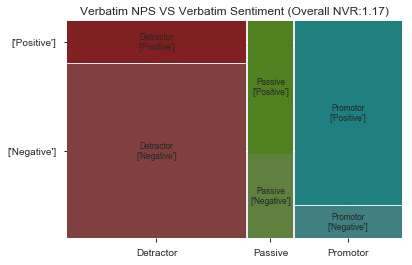

In [24]:
p_neg = df_corr['mode'].value_counts(normalize=True).loc["['Negative']"].round(2)*100
p_pos = df_corr['mode'].value_counts(normalize=True).loc["['Positive']"].round(2)*100
p_nvr = str(round(p_neg/p_pos,2))

mosaic(df_corr.sort_values(by=['NPS','mode']),['NPS','mode'],
       title='Verbatim NPS VS Verbatim Sentiment (Overall NVR:'+p_nvr+')')
marginal = pd.crosstab([df_corr.NPS],df_corr['mode'], margins=True)
chi2result = scipy.stats.chi2_contingency(marginal.iloc[:5,:2])
chi2p_val = chi2result[1]
print('p-value: '+str(chi2p_val))

p-value: 0.0


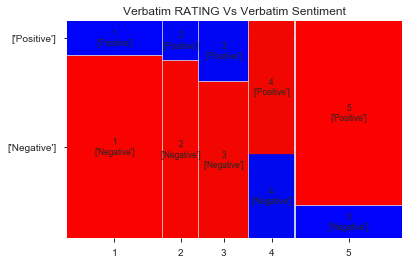

In [25]:
mosaic(df_corr.sort_values(by=['Feedback_Rating','mode']),['Feedback_Rating','mode'],
       title='Verbatim RATING Vs Verbatim Sentiment',statistic=True)
marginal = pd.crosstab([df_corr.Feedback_Rating],df_corr['mode'], margins=True)
chi2result = scipy.stats.chi2_contingency(marginal.iloc[:5,:2])
chi2p_val = chi2result[1]
print('p-value: '+str(chi2p_val))

In [26]:
df_corr['Themes'] = df_corr['Verbatim_Themes'].str.strip('[]*"')
df_corr['Themes'] = df_corr['Themes'].str.replace('","',',')
df_corr['Themes'].replace('not mapped','no theme',inplace=True)

In [27]:
df_corr.head()

,Feedback_DateTime,Feedback_Month,Feedback_Rating,Feedback_RatingValue,Feedback_Verbatim,Verbatim_Themes,Verbatim_Details,week_year,Sentences,Modes,mode,count,NPS,Themes
Feedback_ID,,,,,,,,,,,,,,
f116af54-22c4-4315-9f17-d4f0b0766fee,2018-07-01 07:21:36,2018-07-31,3,-100,It is very good on laptops but all my employee...,"[""outlook""]","[""{\""FeedbackSentencesId\"": 545692,\""Sentence\...",2018-07-01/2018-07-07,"[Positive, Positive]","([Positive], [2])",['Positive'],[2],Detractor,outlook
98d78aa6-b562-459b-a85a-e1598ad39f13,2018-07-01 11:53:12,2018-07-31,1,-100,Very difficult,"[""not mapped""]","[""{\""FeedbackSentencesId\"": 345492,\""Sentence\...",2018-07-01/2018-07-07,[Negative],"([Negative], [1])",['Negative'],[1],Detractor,no theme
0be16e62-f736-47a6-b535-94e3a3b40a1b,2018-07-01 17:31:03,2018-07-31,5,100,MS 365 is a powerful and reasonably easy to us...,"[""not mapped""]","[""{\""FeedbackSentencesId\"": 26404,\""Sentence\""...",2018-07-01/2018-07-07,[Negative],"([Negative], [1])",['Negative'],[1],Promotor,no theme
952fb4a0-7201-4409-acda-049edcd44e2c,2018-07-01 23:03:11,2018-07-31,2,-100,Painful native apps on Mac,"[""version platform""]","[""{\""FeedbackSentencesId\"": 337265,\""Sentence\...",2018-07-01/2018-07-07,[Positive],"([Positive], [1])",['Positive'],[1],Detractor,version platform
5c7ba6c5-644c-4f4f-9abd-cedac3729f93,2018-07-01 23:40:40,2018-07-31,1,-100,NEVER again purchase through go daddy web,"[""admin""]","[""{\""FeedbackSentencesId\"": 208362,\""Sentence\...",2018-07-01/2018-07-07,[Positive],"([Positive], [1])",['Positive'],[1],Detractor,admin


In [28]:
list_col = df_corr['Themes'].dropna().drop_duplicates().str.split(',')
merged_list = []
for item in list_col:
    merged_list.extend(item)

topics = sorted(list(set(merged_list)))

for i, item in enumerate(topics):
    new_col_name = item.upper()
    df_corr[new_col_name] = df_corr['Themes'].str.contains(item)*1

In [29]:
vtheme_counts = df_corr.iloc[:,-len(topics):].sum()
vtheme_counts[vtheme_counts>1000]

ACCOUNT                         2101
ADMIN                           4415
CHANGE MANAGEMENT               1234
EASE_OF_USE                     7638
EASEOFUSE-GENERALCOMPLEXITY     2767
EASEOFUSE-HOWTO                 1502
EASEOFUSE-POPUP                 1444
EASEOFUSE-VERSION               1414
INFORMATION PROTECTION          1368
NO THEME                       13204
ONEDRIVE                        1106
OUTLOOK                         3830
PERFORMANCE                     1557
RECOMMEND                       2172
SKYPE                           1146
SKYPE FOR BUSINESS              1126
SUBSCRIPTION VALUE              3150
SUPPORT                         2870
dtype: int64

In [30]:
verbatim_themes_to_trend = list(vtheme_counts[vtheme_counts>1000].index)
verbatim_themes_to_trend.remove('NO THEME')
verbatim_themes_to_trend.remove('EASE_OF_USE')

## Verbatim Modeling

In [31]:
y = df_by_sentence_position['Feedback_RatingValue']
X = df_by_sentence_position.drop(columns='Feedback_RatingValue')

In [32]:
X = X.loc[:,:'Sentence 16']

In [33]:
X.head()

,NSR_per_verbatim,Sentence 1,Sentence 2,Sentence 3,Sentence 4,Sentence 5,Sentence 6,Sentence 7,Sentence 8,Sentence 9,Sentence 10,Sentence 11,Sentence 12,Sentence 13,Sentence 14,Sentence 15,Sentence 16
Feedback_ID,,,,,,,,,,,,,,,,,
f116af54-22c4-4315-9f17-d4f0b0766fee,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98d78aa6-b562-459b-a85a-e1598ad39f13,1.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0be16e62-f736-47a6-b535-94e3a3b40a1b,1.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
952fb4a0-7201-4409-acda-049edcd44e2c,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5c7ba6c5-644c-4f4f-9abd-cedac3729f93,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X.replace('Neutral',0,inplace=True)

In [35]:
singular_matrix_cutoff = X.shape[1]
rank_test = X
for i in range(rank_test.shape[1]):
    df_to_rank = rank_test.iloc[:,:i+1]
    if i ==np.linalg.matrix_rank(df_to_rank):
        singular_matrix_cutoff = i
singular_matrix_cutoff

17

In [36]:
X = X.iloc[:,:singular_matrix_cutoff]

In [37]:
mlogit = sm.Logit(y, sm.add_constant(X))
fmlogit = mlogit.fit()
print('VERBATIM LENGTH & NSR MODEL',fmlogit.summary())

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.493442
         Iterations 6
VERBATIM LENGTH & NSR MODEL                             Logit Regression Results                            
Dep. Variable:     Feedback_RatingValue   No. Observations:                33974
Model:                            Logit   Df Residuals:                    33956
Method:                             MLE   Df Model:                           17
Date:                  Tue, 03 Mar 2020   Pseudo R-squ.:                  0.2846
Time:                          07:59:57   Log-Likelihood:                -16764.
converged:                         True   LL-Null:                       -23435.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.6916      0.048    -14.410   

In [38]:
X = X.join(df_corr.loc[:,verbatim_themes_to_trend])

In [39]:
X.fillna(0,inplace=True)

In [40]:
mlogit = sm.Logit(y, sm.add_constant(X))
fmlogit = mlogit.fit()
print('VERBATIM THEME, LENGTH & NSR MODEL',fmlogit.summary())

Optimization terminated successfully.
         Current function value: 0.473460
         Iterations 7
VERBATIM THEME, LENGTH & NSR MODEL                             Logit Regression Results                            
Dep. Variable:     Feedback_RatingValue   No. Observations:                33974
Model:                            Logit   Df Residuals:                    33940
Method:                             MLE   Df Model:                           33
Date:                  Tue, 03 Mar 2020   Pseudo R-squ.:                  0.3136
Time:                          07:59:58   Log-Likelihood:                -16085.
converged:                         True   LL-Null:                       -23435.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                  

In [41]:
coefficients = fmlogit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|z|']<0.1]
coefficients['FinalProbability'] = np.exp(coefficients['Coef.'].round(1))*y.value_counts(normalize=True).loc[1] #- 0.5
coefficients['FinalProbability'] = coefficients['FinalProbability'].mask(coefficients['FinalProbability']>=1,0.99)
coefficients['Lift'] = coefficients['FinalProbability'] - y.value_counts(normalize=True).loc[1]
coefficients.round(2)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],FinalProbability,Lift
const,-0.92,0.05,-17.76,0.00,-1.02,-0.82,0.22,-0.32
NSR_per_verbatim,1.61,0.10,16.04,0.00,1.41,1.81,0.99,0.45
Sentence 1,-0.59,0.04,-13.25,0.00,-0.67,-0.50,0.30,-0.24
Sentence 2,-0.12,0.03,-3.81,0.00,-0.19,-0.06,0.49,-0.05
Sentence 3,-0.09,0.04,-2.18,0.03,-0.18,-0.01,0.49,-0.05
Sentence 12,1.38,0.50,2.77,0.01,0.41,2.36,0.99,0.45
Sentence 16,-2.51,1.32,-1.90,0.06,-5.10,0.08,0.04,-0.50
ACCOUNT,0.30,0.06,4.72,0.00,0.18,0.43,0.73,0.19
ADMIN,0.18,0.04,4.23,0.00,0.10,0.27,0.66,0.12
CHANGE MANAGEMENT,0.42,0.08,4.96,0.00,0.25,0.58,0.81,0.27


# Sentence Level

In [42]:
sentence_level_df = pd.DataFrame(columns=['FeedbackID','Sentence','MLTheme',
                                          'SentimentClass','SentimentProba']) #By Sentence, By Not Verbatim
for V, ix, Week in zip(Verbatim_Details, Verbatim_Details.index, Verbatim_Dates):
    j = json.loads(V)
    for S in j:
        l = S.split(',')
        #print(l,j,S)
        ID = int(l[0].split(':')[1].strip(" '"))
        Line = ','.join([x.rpartition('"Sentence": ')[2].strip('""') for x in l[1:-3]])
        #Line = sentence[1]
        Theme = find_between(l[-3],'["','"]')
        Class = find_between(l[-2].split(':')[1],'"','"')
        Prob = find_between(l[-1],":","}").strip().strip('"')
        sentence_level_df.loc[ID] = [ix,Line,Theme,Class,Prob]

In [43]:
sentence_level_df['Feedback_DateTime'] = sentence_level_df.FeedbackID.map(DateTime_Dict)
sentence_level_df['week_year'] = sentence_level_df.Feedback_DateTime.dt.to_period('W-SAT')

In [44]:
themes_to_trend = ['admin', 'customer support', 'outlook', 'marketing',# 'subscription value',
                   'onedrive', 'sharepoint', 'commerce']

for i, item in enumerate(themes_to_trend):
    new_col_name = item#.upper()
    sentence_level_df[new_col_name] = sentence_level_df['MLTheme'].str.contains(item)*1

In [45]:
sentence_level_df.head(5)

,FeedbackID,Sentence,MLTheme,SentimentClass,SentimentProba,Feedback_DateTime,week_year,admin,customer support,outlook,marketing,onedrive,sharepoint,commerce
545692,f116af54-22c4-4315-9f17-d4f0b0766fee,#N#It was working with OWA but now the app is ...,outlook,Positive,0.927981,2018-07-01 07:21:36,2018-07-01/2018-07-07,0,0,1,0,0,0,0
545691,f116af54-22c4-4315-9f17-d4f0b0766fee,It is very good on laptops but all my employee...,outlook,Positive,0.916740,2018-07-01 07:21:36,2018-07-01/2018-07-07,0,0,1,0,0,0,0
345492,98d78aa6-b562-459b-a85a-e1598ad39f13,Very difficult,not mapped,Negative,0.242879,2018-07-01 11:53:12,2018-07-01/2018-07-07,0,0,0,0,0,0,0
26404,0be16e62-f736-47a6-b535-94e3a3b40a1b,MS 365 is a powerful and reasonably easy to us...,not mapped,Negative,0.037441,2018-07-01 17:31:03,2018-07-01/2018-07-07,0,0,0,0,0,0,0
337265,952fb4a0-7201-4409-acda-049edcd44e2c,Painful native apps on Mac,not mapped,Positive,0.576117,2018-07-01 23:03:11,2018-07-01/2018-07-07,0,0,0,0,0,0,0


In [46]:
dictfile = pd.read_csv('tenant_nps_dict(commerce_update).csv')
dictfile['Labels'] = dictfile['Labels'].str.lower()
dictfile = dictfile.groupby(['Labels'])['Triggers'].apply(', '.join).reset_index()
dictionary_df = dictfile.groupby(['Labels'])['Triggers'].apply(', '.join).reset_index()
keys   = dictionary_df['Labels']
values = dictionary_df['Triggers'].str.split(',')
dictionary = {}
for k,v in zip(keys,values):
    dictionary[k.lower()]=v

from NgramClassifier import NgramClassifier
import nps_uplift

clf = NgramClassifier(4)
clf.load_dictionary('tenant_nps_dict(commerce_update).csv')
#clf.dictionary[:5]

text = sentence_level_df['Sentence']
predictions, triggers = clf.predict([str(t) for t in text])

sentence_level_df['RBCTheme'] = predictions

{'activate': ['commerce'], 'activation': ['commerce', 'commerce', 'admin'], 'activation problem': ['commerce'], 'activation problems': ['commerce'], 'bill': ['commerce'], 'billing': ['commerce', 'admin'], 'card': ['commerce'], 'card expired': ['commerce'], 'charge': ['commerce', 'commerce', 'subscription value'], 'charges': ['commerce'], 'credit card': ['commerce'], 'debit card': ['commerce'], 'expire': ['commerce'], 'expired': ['commerce', 'commerce'], 'fee': ['commerce', 'subscription value'], 'fees': ['commerce', 'subscription value'], 'invoice': ['commerce'], 'invoiced': ['commerce'], 'licence': ['commerce', 'account'], 'licence key': ['commerce', 'account'], 'licence keys': ['commerce'], 'payed': ['commerce', 'subscription value'], 'payment': ['commerce', 'subscription value', 'account'], 'renew': ['commerce', 'subscription value', 'account'], 'renewal': ['commerce', 'commerce', 'subscription value', 'account'], 'renewed': ['commerce', 'subscription value'], 'renews': ['commerce',

In [47]:
sentence_level_df['Feedback_RatingValue'] = sentence_level_df['FeedbackID'].map(NPS_Dict)
sentence_level_df['Feedback_Rating'] = sentence_level_df['FeedbackID'].map(Rating_Dict)
#sentence_level_df['Feedback_RatingValue'] = sentence_level_df['FeedbackID'].map(NSR_Dict)

#sentence_level_df['NegSentenceRatio'] = sentence_level_df['FeedbackID'].map(NSR_Dict)
#sentence_level_df['BottomBoxRatio'] = sentence_level_df['FeedbackID'].map(BBR_Dict)

In [48]:
### Sentence Level BBR
bbr_dict = {}
for t in themes_to_trend:
    #print(t)
    theme_df = sentence_level_df[sentence_level_df[t]==1]
    #print(theme_df.Feedback_Rating.value_counts())
    if len(theme_df) != 0:
        bbr = len(theme_df[theme_df.Feedback_RatingValue==-100])/len(theme_df)
    else:
        bbr = 0
    bbr_dict[t] = round(bbr,3)

bbr_df = pd.DataFrame(index = bbr_dict.keys(),columns=['BBR'],data = bbr_dict.values())
bbr_df

,BBR
admin,0.724
customer support,0.618
outlook,0.777
marketing,0.586
onedrive,0.614
sharepoint,0.697
commerce,0.823


In [49]:
sentence_level_df['NPS'] = sentence_level_df['Feedback_RatingValue'].copy()
sentence_level_df['NPS'].replace(-100,'Detractor',inplace=True)
sentence_level_df['NPS'].replace(0,'Passive',inplace=True)
sentence_level_df['NPS'].replace(100,'Promotor',inplace=True)

In [50]:
print(sentence_level_df.shape)
sentence_level_df = sentence_level_df[sentence_level_df['SentimentClass']!='']
sentence_level_df = sentence_level_df[sentence_level_df['SentimentProba']!='']
sentence_level_df.shape

(65164, 18)


(52002, 18)

In [51]:
sentence_level_df['SentimentProba'] = sentence_level_df['SentimentProba'].astype(float)

In [52]:
sentence_level_df.SentimentClass.value_counts(normalize=True)

Negative    0.539941
Positive    0.460059
Name: SentimentClass, dtype: float64

p-value: 0.0


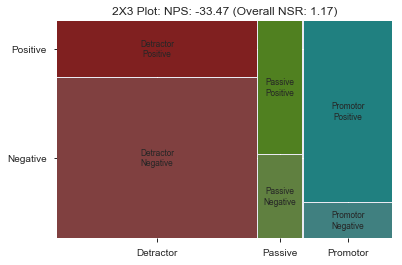

In [53]:
p_neg = (sentence_level_df.SentimentClass.value_counts(normalize=True).loc['Negative'].round(2)*100)
p_pos = (sentence_level_df.SentimentClass.value_counts(normalize=True).loc['Positive'].round(2)*100)
p_nsr = str(round(p_neg/p_pos,2))
mosaic(sentence_level_df.sort_values(by=['NPS','SentimentClass']),['NPS','SentimentClass'],
       title='2X3 Plot: NPS: '+str(round(sentence_level_df.Feedback_RatingValue.mean(),2))+ \
            ' (Overall NSR: '+p_nsr+')')
marginal = pd.crosstab([sentence_level_df.NPS],sentence_level_df['SentimentClass'], margins=True)
chi2result = scipy.stats.chi2_contingency(marginal.iloc[:3,:2])
chi2p_val = chi2result[1]
print('p-value: '+str(chi2p_val))

### Neutral Class Example

In [54]:
# sentence_level_df['SentimentProba'] = sentence_level_df['SentimentProba'].replace('',0.5).astype(float)
# sentence_level_df.loc[sentence_level_df['SentimentProba'].between(0.25,0.75),'SentimentClass']='Neutral'

# p_neg = (sentence_level_df.SentimentClass.value_counts(normalize=True).loc['Negative'].round(2)*100)
# p_pos = (sentence_level_df.SentimentClass.value_counts(normalize=True).loc['Positive'].round(2)*100)
# p_nsr = str(round(p_neg/p_pos,2))
# mosaic(sentence_level_df.sort_values(by=['NPS','SentimentClass']),['NPS','SentimentClass'],
#       title='Verbatim NPS Vs Sentence Sentiment (Percent Negative: '+p_neg+','+' Percent Positive: '+p_pos+')')
# marginal = pd.crosstab([sentence_level_df.NPS],sentence_level_df['SentimentClass'], margins=True)
# marginal = pd.crosstab([sentence_level_df.NPS],sentence_level_df['SentimentClass'], margins=True)
# chi2result = scipy.stats.chi2_contingency(marginal.iloc[:3,:2])
# chi2p_val = chi2result[1]
# print('p-value: '+str(chi2p_val))

### By Individual Feedback Rating (1-5)

In [55]:
props5 = lambda key: {'color': 'cornflowerblue' if 5 in key else 'grey'}

In [56]:
lambda x: x+2

<function __main__.<lambda>(x)>

p-value: 0.0


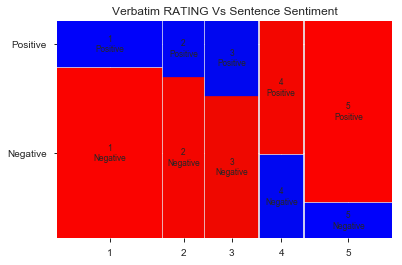

In [57]:
mosaic(sentence_level_df.sort_values(by='Feedback_Rating'),['Feedback_Rating','SentimentClass'],#properties = props5,
      title='Verbatim RATING Vs Sentence Sentiment',statistic=True)
marginal = pd.crosstab([sentence_level_df.Feedback_Rating],sentence_level_df['SentimentClass'], margins=True)
chi2result = scipy.stats.chi2_contingency(marginal.iloc[:5,:2])
chi2p_val = chi2result[1]
print('p-value: '+str(chi2p_val))

### By Topic

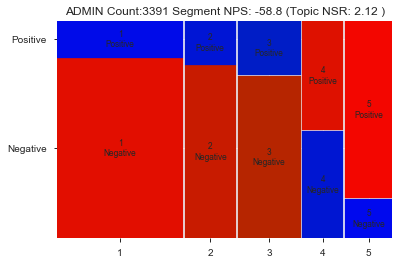

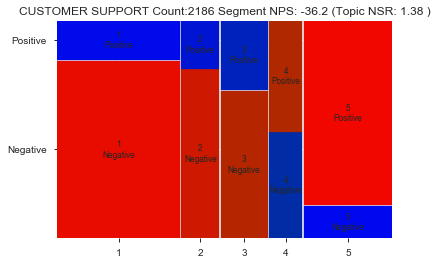

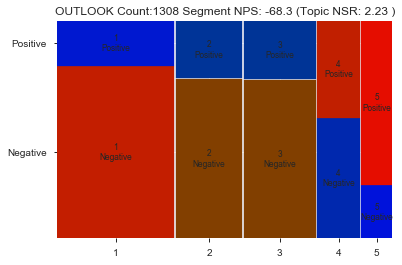

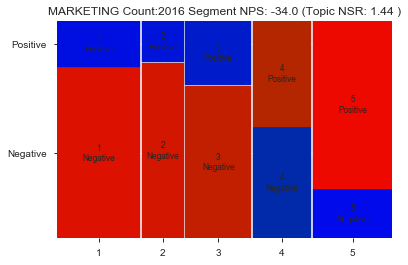

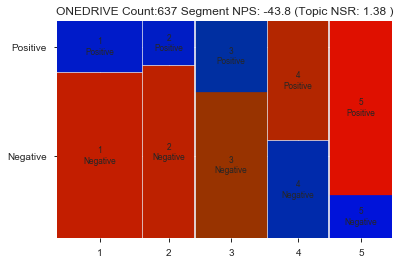

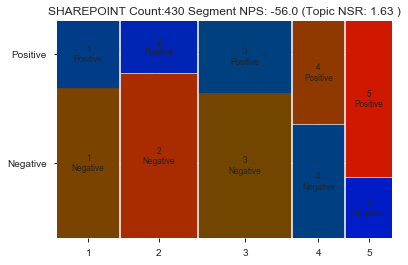

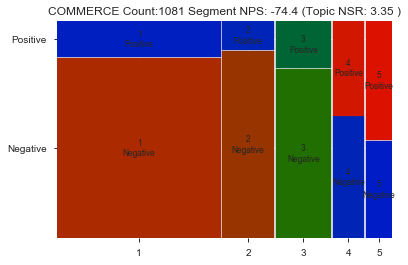

In [58]:
for t in themes_to_trend:
    topic = sentence_level_df[sentence_level_df[t]==1]
    #p_det = str(topic.NPS.value_counts(normalize=True).loc['Detractor'].round(1)*100)
    #p_pro = str(topic.NPS.value_counts(normalize=True).loc['Promotor'].round(1)*100)
    p_neg = (topic.SentimentClass.value_counts(normalize=True).loc['Negative'].round(2)*100)
    p_pos = (topic.SentimentClass.value_counts(normalize=True).loc['Positive'].round(2)*100)
    t_nsr = str(round(p_neg/p_pos,2))
    mosaic(topic.sort_values(by=['Feedback_Rating','SentimentClass']),['Feedback_Rating','SentimentClass'],
           statistic=True, title=t.upper()+' Count:'+str(len(topic))+' Segment NPS: '+str(round(topic.Feedback_RatingValue.mean(),1))+ \
           ' (Topic NSR: '+t_nsr+' )')

## Sentence Modeling

In [59]:
y = sentence_level_df['Feedback_RatingValue'].replace(100,0).replace(-100,1)
X = sentence_level_df.loc[:,['SentimentClass','SentimentProba']+themes_to_trend]

In [60]:
X['SentimentClass']=(X['SentimentClass']=='Negative')*1

In [61]:
X.dtypes

SentimentClass        int32
SentimentProba      float64
admin                 int32
customer support      int32
outlook               int32
marketing             int32
onedrive              int32
sharepoint            int32
commerce              int32
dtype: object

In [62]:
mlogit = sm.Logit(y, sm.add_constant(X))
fmlogit = mlogit.fit()

print('BY SENTENCE MODEL',fmlogit.summary())

Optimization terminated successfully.
         Current function value: 0.513823
         Iterations 6
BY SENTENCE MODEL                             Logit Regression Results                            
Dep. Variable:     Feedback_RatingValue   No. Observations:                52002
Model:                            Logit   Df Residuals:                    51992
Method:                             MLE   Df Model:                            9
Date:                  Tue, 03 Mar 2020   Pseudo R-squ.:                  0.2359
Time:                          09:04:05   Log-Likelihood:                -26720.
converged:                         True   LL-Null:                       -34968.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.7710      0.068     40.786      0.000  

In [63]:
coefficients = fmlogit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|z|']<0.1]
coefficients.drop('const').round(2)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
SentimentClass,-0.87,0.06,-14.24,0.00,-0.99,-0.75
SentimentProba,-3.89,0.07,-52.48,0.00,-4.04,-3.75
admin,0.44,0.05,9.37,0.00,0.35,0.53
customer support,0.12,0.05,2.20,0.03,0.01,0.23
outlook,0.73,0.08,9.51,0.00,0.58,0.88
marketing,-0.20,0.06,-3.64,0.00,-0.31,-0.09
sharepoint,0.40,0.12,3.24,0.00,0.16,0.64
commerce,0.78,0.09,8.45,0.00,0.60,0.96


In [64]:
df_by_sentence_position.shape,sentence_level_df.shape

((33974, 24), (52002, 18))

# Time Series Analysis

In [65]:
df_ts = df_details.copy()

themes_dict = {}
for V, ix in zip(Verbatim_Details, Verbatim_Details.index):
    #Verbatim_Sample = Verbatim_Details.iloc[0]
    j = json.loads(V)
    themes = []

    for S in j:
        S = S.split(',')
        for AT in [item for item in S if item.find('AdminTheme')!=-1]:
            theme = find_between(AT,'["','"]')
            themes.append(theme)
    themes_dict[ix] = ','.join(list(set(themes)))
    
themes = pd.Series(themes_dict)

In [66]:
df_ts.head()

,Feedback_DateTime,Feedback_Month,Feedback_Rating,Feedback_RatingValue,Feedback_Verbatim,Verbatim_Themes,Verbatim_Details,week_year,Sentences
Feedback_ID,,,,,,,,,
f116af54-22c4-4315-9f17-d4f0b0766fee,2018-07-01 07:21:36,2018-07-31,3,-100,It is very good on laptops but all my employee...,"[""outlook""]","[""{\""FeedbackSentencesId\"": 545692,\""Sentence\...",2018-07-01/2018-07-07,"[Positive, Positive]"
98d78aa6-b562-459b-a85a-e1598ad39f13,2018-07-01 11:53:12,2018-07-31,1,-100,Very difficult,"[""not mapped""]","[""{\""FeedbackSentencesId\"": 345492,\""Sentence\...",2018-07-01/2018-07-07,[Negative]
0be16e62-f736-47a6-b535-94e3a3b40a1b,2018-07-01 17:31:03,2018-07-31,5,100,MS 365 is a powerful and reasonably easy to us...,"[""not mapped""]","[""{\""FeedbackSentencesId\"": 26404,\""Sentence\""...",2018-07-01/2018-07-07,[Negative]
952fb4a0-7201-4409-acda-049edcd44e2c,2018-07-01 23:03:11,2018-07-31,2,-100,Painful native apps on Mac,"[""version platform""]","[""{\""FeedbackSentencesId\"": 337265,\""Sentence\...",2018-07-01/2018-07-07,[Positive]
5c7ba6c5-644c-4f4f-9abd-cedac3729f93,2018-07-01 23:40:40,2018-07-31,1,-100,NEVER again purchase through go daddy web,"[""admin""]","[""{\""FeedbackSentencesId\"": 208362,\""Sentence\...",2018-07-01/2018-07-07,[Positive]


In [67]:
themes.fillna('',inplace=True)
themes = themes.str.replace('not mapped','')
themes = themes.str.replace('other','')
themes = themes.replace('no theme','')
themes = themes.str.strip(',')

In [68]:
i = 1
while sum(themes.str.contains(',,'))>0:
    print('Time ',i)
    print('From ',sum(themes.str.contains(',,')))
    themes = themes.str.replace(',,',',')
    print('To ',sum(themes.str.contains(',,')))
    i+=1

Time  1
From  462
To  74
Time  2
From  74
To  0


In [69]:
themes.replace('','no theme',inplace=True)
themes = themes.str.split(',').apply(set).apply(list)
themes = themes.astype(str).str.strip('[]')
themes = themes.str.replace(" '","'")
themes = themes.str.replace("'","")

In [70]:
df_ts['Verbatim_DetailsThemes'] = df_ts.index.map(themes)

In [71]:
df_ts["Feedback_DateTime"] = df_ts["Feedback_DateTime"].apply(lambda x: pd.to_datetime(x))
df_ts['week_year'] = df_ts.Feedback_DateTime.dt.to_period('W-SAT')

In [72]:
for i, item in enumerate(themes_to_trend):
    new_col_name = item#.upper()
    df_ts[new_col_name] = df_ts['Verbatim_DetailsThemes'].str.contains(item)*1

In [73]:
WoW_all_Verbatim = df_ts.groupby(['week_year'])[themes_to_trend].sum()
WoW_det = df_ts[df_ts.Feedback_Rating.isin([1,2,3])].groupby(['week_year'])[themes_to_trend].sum()

In [74]:
WoW_BBR = WoW_det.divide(WoW_all_Verbatim).round(3)
WoW_BBR = WoW_BBR.add_prefix('BBR_')

In [75]:
WoW_BBR_All = df_ts.groupby(['week_year'])['Feedback_RatingValue'].value_counts(normalize=True).loc[:,-100]

In [76]:
sentence_level_df.SentimentClass.value_counts(normalize=True)

Negative    0.539941
Positive    0.460059
Name: SentimentClass, dtype: float64

In [77]:
WoW_neg_all = sentence_level_df[sentence_level_df.SentimentClass=='Negative'].groupby(['week_year'])['SentimentClass'].count()
WoW_pos_all = sentence_level_df[sentence_level_df.SentimentClass=='Positive'].groupby(['week_year'])['SentimentClass'].count()
WoW_NSR_All = (WoW_neg_all/WoW_pos_all).round(2)

In [78]:
WoW_all_Sentence = sentence_level_df.groupby(['week_year'])[themes_to_trend].sum()
WoW_neg = sentence_level_df[sentence_level_df.SentimentProba<=0.3].groupby(['week_year'])[themes_to_trend].sum()
WoW_NSR = WoW_neg.divide(WoW_all_Sentence).round(3)
WoW_NSR

,admin,customer support,outlook,marketing,onedrive,sharepoint,commerce
week_year,,,,,,,
2018-07-01/2018-07-07,0.333,0.400,0.273,0.250,0.500,0.000,0.182
2018-07-08/2018-07-14,0.419,0.273,0.455,0.125,0.000,0.500,0.500
2018-07-15/2018-07-21,0.467,0.240,0.308,0.304,0.000,0.400,0.250
2018-07-22/2018-07-28,0.333,0.357,0.111,0.217,0.222,0.200,0.286
2018-07-29/2018-08-04,0.400,0.250,0.083,0.304,0.167,0.000,0.455
...,...,...,...,...,...,...,...
2019-10-27/2019-11-02,0.746,0.767,0.773,0.640,0.286,0.333,0.889
2019-11-03/2019-11-09,0.855,0.769,1.000,0.471,0.615,1.000,0.857
2019-11-10/2019-11-16,0.767,0.700,0.684,0.750,0.333,0.500,0.929


In [79]:
WoW_NSR = WoW_NSR.add_prefix('NSR_')

In [80]:
print('NSR as ratio of negative over positive:')
WoW_NSR_All 

NSR as ratio of negative over positive:


week_year
2018-07-01/2018-07-07    0.72
2018-07-08/2018-07-14    0.67
2018-07-15/2018-07-21    0.66
2018-07-22/2018-07-28    0.58
2018-07-29/2018-08-04    0.49
                         ... 
2019-10-27/2019-11-02    1.93
2019-11-03/2019-11-09    2.05
2019-11-10/2019-11-16    1.92
2019-11-17/2019-11-23    1.04
2019-11-24/2019-11-30    0.72
Freq: W-SAT, Name: SentimentClass, Length: 74, dtype: float64

In [81]:
#WoW_NSR = sentence_level_df.groupby(['week_year'])['SentimentClass'].value_counts(normalize=True).loc[:,'Negative']
print('NSR as ratio of negative over everything:')
WoW_NSR_All = sentence_level_df.groupby(['week_year'])['SentimentClass'].value_counts(normalize=True).loc[:,'Negative']

NSR as ratio of negative over everything:


In [82]:
WoW_NSR_All

week_year
2018-07-01/2018-07-07    0.419847
2018-07-08/2018-07-14    0.400000
2018-07-15/2018-07-21    0.396963
2018-07-22/2018-07-28    0.367188
2018-07-29/2018-08-04    0.327511
                           ...   
2019-10-27/2019-11-02    0.658151
2019-11-03/2019-11-09    0.671875
2019-11-10/2019-11-16    0.657761
2019-11-17/2019-11-23    0.509722
2019-11-24/2019-11-30    0.417112
Freq: W-SAT, Name: SentimentClass, Length: 74, dtype: float64

## Time Series Modeling

In [83]:
y = df.groupby(['week_year'])['Feedback_RatingValue'].mean()
X = pd.concat([WoW_NSR_All,WoW_NSR,WoW_BBR_All,WoW_BBR],axis=1)

In [84]:
X.tail(10)

,SentimentClass,NSR_admin,NSR_customer support,NSR_outlook,NSR_marketing,NSR_onedrive,NSR_sharepoint,NSR_commerce,Feedback_RatingValue,BBR_admin,BBR_customer support,BBR_outlook,BBR_marketing,BBR_onedrive,BBR_sharepoint,BBR_commerce
week_year,,,,,,,,,,,,,,,,
2019-11-17/2019-11-23,0.509722,0.651,0.540,0.656,0.488,0.765,0.7,0.939,0.435996,0.679,0.551,0.700,0.476,0.571,0.667,0.839
2019-11-24/2019-11-30,0.417112,0.800,0.333,1.000,0.167,0.400,0.0,0.714,0.442177,0.766,0.538,0.824,0.667,0.429,0.500,0.844
2019-12-01/2019-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446678,0.776,0.558,0.739,0.672,0.375,0.769,0.800
2019-12-08/2019-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463537,0.732,0.593,0.889,0.593,0.632,0.455,0.867
2019-12-15/2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433460,0.670,0.463,0.767,0.400,0.727,0.500,0.742
2019-12-22/2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413580,0.550,0.562,0.583,0.536,0.900,1.000,0.846
2019-12-29/2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.443888,0.636,0.519,0.773,0.625,0.286,0.750,0.762
2020-01-05/2020-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.443981,0.582,0.562,0.682,0.714,0.412,0.667,0.800
2020-01-12/2020-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444517,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
X.rename(columns={'SentimentClass':'NSR_Overall','Feedback_RatingValue':'BBR_Overall'},inplace=True)

In [86]:
X.tail(10)

,NSR_Overall,NSR_admin,NSR_customer support,NSR_outlook,NSR_marketing,NSR_onedrive,NSR_sharepoint,NSR_commerce,BBR_Overall,BBR_admin,BBR_customer support,BBR_outlook,BBR_marketing,BBR_onedrive,BBR_sharepoint,BBR_commerce
week_year,,,,,,,,,,,,,,,,
2019-11-17/2019-11-23,0.509722,0.651,0.540,0.656,0.488,0.765,0.7,0.939,0.435996,0.679,0.551,0.700,0.476,0.571,0.667,0.839
2019-11-24/2019-11-30,0.417112,0.800,0.333,1.000,0.167,0.400,0.0,0.714,0.442177,0.766,0.538,0.824,0.667,0.429,0.500,0.844
2019-12-01/2019-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446678,0.776,0.558,0.739,0.672,0.375,0.769,0.800
2019-12-08/2019-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463537,0.732,0.593,0.889,0.593,0.632,0.455,0.867
2019-12-15/2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433460,0.670,0.463,0.767,0.400,0.727,0.500,0.742
2019-12-22/2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413580,0.550,0.562,0.583,0.536,0.900,1.000,0.846
2019-12-29/2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.443888,0.636,0.519,0.773,0.625,0.286,0.750,0.762
2020-01-05/2020-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.443981,0.582,0.562,0.682,0.714,0.412,0.667,0.800
2020-01-12/2020-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444517,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is currently an 8-week lag between a Verbatim being added in DataMart and generation the corresponding in Verbatim_Details field. 

In [87]:
y = y.iloc[:-8]
X = X.iloc[:-8,:]

In [88]:
for col in X.columns:
    X.loc[X[col].isnull(), col] = X[col].median()

In [89]:
#pandas_profiling.ProfileReport(X.reset_index(drop=True))

#### Initial Model:

In [90]:
m = sm.OLS(y, X)
fm = m.fit()

print('Initial Model',fm.summary())

Initial Model                                   OLS Regression Results                                 
Dep. Variable:     Feedback_RatingValue   R-squared (uncentered):                   0.994
Model:                              OLS   Adj. R-squared (uncentered):              0.993
Method:                   Least Squares   F-statistic:                              644.1
Date:                  Tue, 03 Mar 2020   Prob (F-statistic):                    3.93e-59
Time:                          09:04:33   Log-Likelihood:                         -198.07
No. Observations:                    74   AIC:                                      428.1
Df Residuals:                        58   BIC:                                      465.0
Df Model:                            16                                                  
Covariance Type:              nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.97

BBR is inherently correlated with NPS, but NSR is not

In [91]:
m = sm.OLS(y, X.iloc[:,X.columns.str.startswith('NSR')])
fm = m.fit()

print('Initial Model',fm.summary())

Initial Model                                   OLS Regression Results                                 
Dep. Variable:     Feedback_RatingValue   R-squared (uncentered):                   0.977
Model:                              OLS   Adj. R-squared (uncentered):              0.975
Method:                   Least Squares   F-statistic:                              357.5
Date:                  Tue, 03 Mar 2020   Prob (F-statistic):                    3.03e-51
Time:                          09:04:38   Log-Likelihood:                         -249.64
No. Observations:                    74   AIC:                                      515.3
Df Residuals:                        66   BIC:                                      533.7
Df Model:                             8                                                  
Covariance Type:              nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.97

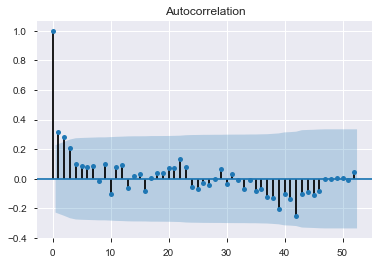

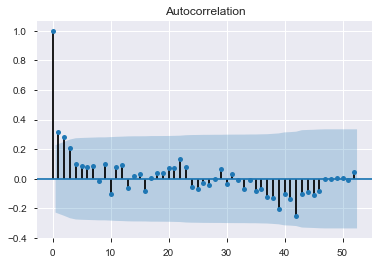

In [92]:
plot_acf(y, lags=52)

## ARIMA Modeling

In [93]:
if 'week_year' in X.columns:
    X.drop('week_year',inplace=True)

In [94]:
def make_arima(y,ar,ma):
    try:
        ARIMA(y,order=(ar,1,ma)).fit(disp=0)
        return True
    except ValueError:
        return False
    except np.linalg.LinAlgError as err:
        return False

In [95]:
print('AR, MA, Log-Likelihood, BIC, AIC')
for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,4,4,5,5,5,5,5,1,2,3],
                 [1,2,3,1,2,3,1,2,3,1,2,3,1,2,1,2,3,4,5,0,0,0]):
    if make_arima(y,ar,ma):
        model = ARIMA(y, order=(ar,1,ma))
        model_fit = model.fit(disp=0)
        ll = float(model_fit.summary2().tables[0].iloc[1,3])
        bic = float(model_fit.summary2().tables[0].iloc[0,3])
        aic = float(model_fit.summary2().tables[0].iloc[8,1])
        print(ar, ma, ll,bic,aic,round(sum([ll*-1,bic,aic]),1))
    
    
#AR = 4, MA = 3 PRODUCES LINEAR ANG ERROR

AR, MA, Log-Likelihood, BIC, AIC
0 1 -129.57 272.0115 265.1402 666.7
0 2 -128.14 273.443 264.2811 665.9
1 1 -127.72 272.604 263.4422 663.8
1 2 -127.11 275.6704 264.2181 667.0
2 1 -127.0 275.4558 264.0035 666.5
2 2 -126.97 279.6772 265.9344 672.6


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2 3 -127.52 285.0751 269.0419 681.6
3 1 -126.94 279.6133 265.8705 672.4
3 2 -125.99 282.0201 265.9869 674.0
3 3 -124.38 283.0798 264.7562 672.2
4 1 -126.79 283.6229 267.5897 678.0
4 2 -126.78 287.8818 269.5582 684.2
5 1 -126.78 287.8765 269.5529 684.2
5 2 -125.98 290.5796 269.9655 686.5


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


5 3 -124.54 291.9756 269.071 685.6


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarni

5 4 -124.95 297.092 271.8969 693.9


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


1 0 -134.56 282.0001 275.1287 691.7
2 0 -132.2 281.5599 272.398 686.2
3 0 -131.76 284.9816 273.5293 690.3


                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   73
Model:                     ARIMA(3, 1, 3)   Log Likelihood                -124.378
Method:                           css-mle   S.D. of innovations              1.264
Date:                    Tue, 03 Mar 2020   AIC                            264.756
Time:                            09:05:14   BIC                            283.080
Sample:                        07-14-2018   HQIC                           272.058
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0227      0.010     -2.178      0.033      -0.043      -0.002
ar.L1.D.Feedback_RatingValue    -0.4815      

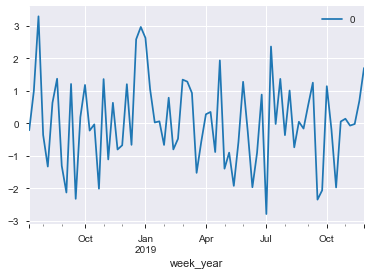

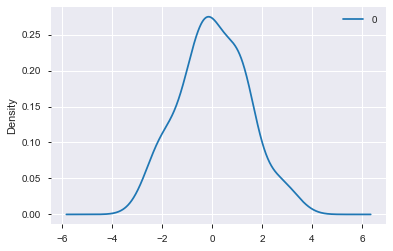

               0
count  73.000000
mean    0.058273
std     1.340894
min    -2.789565
25%    -0.800249
50%    -0.017292
75%     1.054397
max     3.297346


In [96]:
model = ARIMA(y, order=(3,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

The Autoregressor and Moving Average variables look useful. We can pool them with the default covariates to get a superior model:

## ARMIAX: ARIMA + Covariates (e.g. BBR, NSR, etc)

In [97]:
train_test_cutoff = 4*len(y)//5
X_train = X.iloc[:train_test_cutoff]
X_test = X.iloc[train_test_cutoff+1:]
y_train = y.iloc[0:train_test_cutoff]
y_test = y.iloc[train_test_cutoff+1:]

In [98]:
def make_arimaCovar(y,X,ar,ma):
    try:
        ARIMA(y,exog=X,order=(ar,1,ma)).fit(disp=0)
        return True
    except ValueError:
        return False
    except np.linalg.LinAlgError:
        return False

In [99]:
print('AR, MA, Scoring Test Data (Mean Absolute Error)')
for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,1,2,3],
                 [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
    if make_arimaCovar(y_train,X_train,ar,ma):
        train_model = ARIMA(y_train, exog=X_train,order=(ar,1,ma))
        model_fit = train_model.fit(disp=0)
        y_pred = model_fit.forecast(steps=len(X_test),exog=X_test)[0] 
        forecast_error = y_test - y_pred
        mean_absolute_error = np.mean(abs(forecast_error))
        print(ar,ma,round(mean_absolute_error,3))
        #ll = float(model_fit.summary2().tables[0].iloc[1,3])
        #bic = float(model_fit.summary2().tables[0].iloc[0,3])
        #aic = float(model_fit.summary2().tables[0].iloc[8,1])
        #print(ar, ma, ll,bic,aic,round(sum([ll*-1,bic,aic]),1))

AR, MA, Scoring Test Data (Mean Absolute Error)


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 1 0.951


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 2 1.594


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 3 1.68


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1 1.039


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 2 0.984


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 3 1.625


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 1.065


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 2 1.037


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 3 1.595


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 1.011


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 2 1.141


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 3 1.555


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 1.194


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 1.164


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 3 0.992


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 1.453


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 2 2.077


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 3 1.569
1 0 1.765
2 0 1.773
3 0 1.656


Full ARIMA + Covariate Model


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   73
Model:                     ARIMA(0, 1, 1)   Log Likelihood                -110.717
Method:                           css-mle   S.D. of innovations              1.071
Date:                    Tue, 03 Mar 2020   AIC                            259.434
Time:                            09:12:53   BIC                            302.953
Sample:                        07-14-2018   HQIC                           276.777
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1796      1.534      0.117      0.907      -2.827       3.186
NSR_Overall                     15.6717      

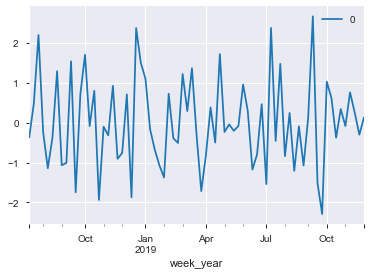

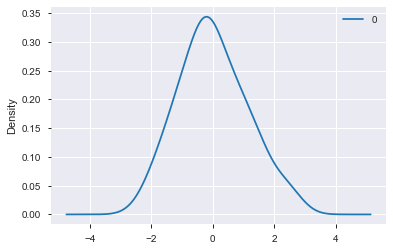

               0
count  73.000000
mean    0.012179
std     1.107506
min    -2.290744
25%    -0.798883
50%    -0.092602
75%     0.723249
max     2.663309


In [100]:
print('Full ARIMA + Covariate Model')
model = ARIMA(y, exog=X,order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [101]:
coefficients = model_fit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|t|']<0.1]

In [102]:
coefficients['Coef.']/100

NSR_customer support           -0.040679
NSR_marketing                  -0.024836
NSR_commerce                   -0.023930
BBR_admin                       0.056236
BBR_onedrive                   -0.011305
BBR_sharepoint                 -0.011662
ma.L1.D.Feedback_RatingValue   -0.009999
Name: Coef., dtype: float64

Before lagging independent variables, NSR appears to be a more significant features than BBR Overall. Some of the theme-level BBR's are also more insifhtful than Overall BBR at this point.

### Lagging Independent Variables

We suspect the relationship bewtween these NSR/BBR Metrics and NPS has a delayed effect. So the BBR for one week may affect the NPS in a matter of a few weeks. We should also generate Autocorrelation functions for the predictive variables to get an idea of what lags would not violate the assumption of serially correlated error. 

How to read: Within the blue shaded line means the given period lag (X-Axis) does not have an unreliable degree of autocorrelation.

NSR_Overall
NSR_admin
NSR_customer support
NSR_outlook
NSR_marketing
NSR_onedrive
NSR_sharepoint
NSR_commerce
BBR_Overall
BBR_admin
BBR_customer support
BBR_outlook
BBR_marketing
BBR_onedrive
BBR_sharepoint
BBR_commerce


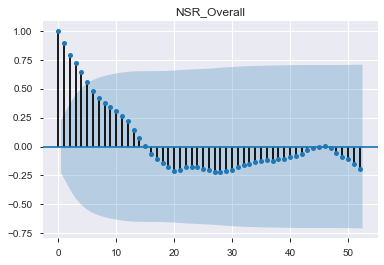

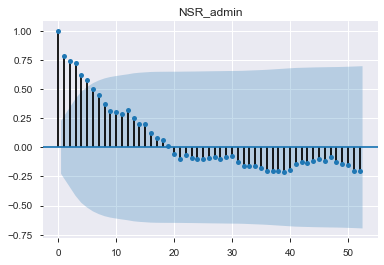

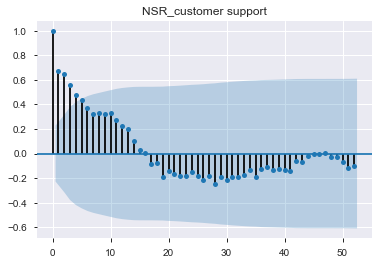

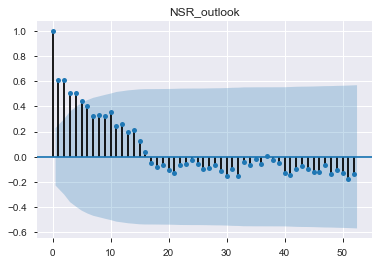

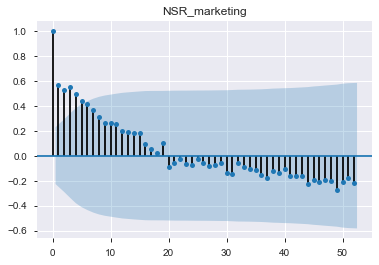

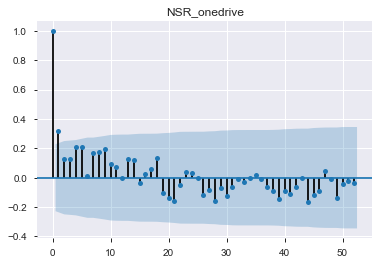

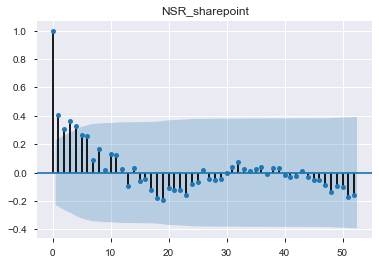

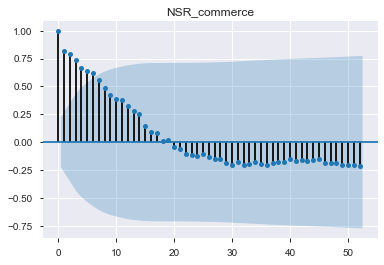

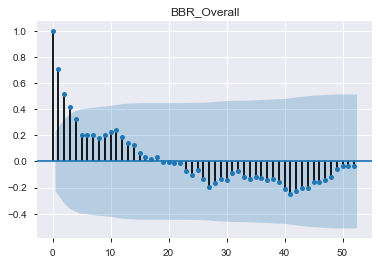

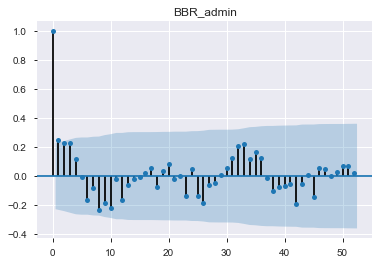

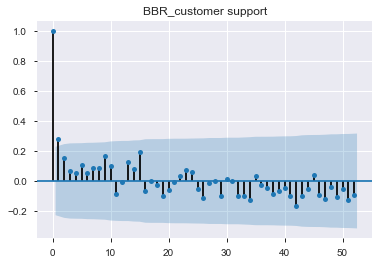

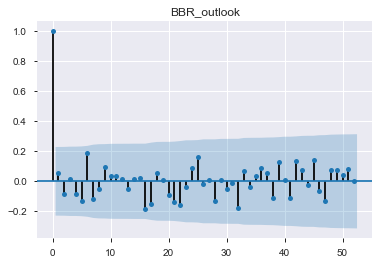

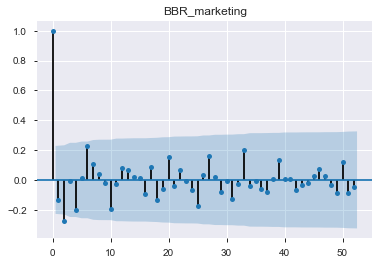

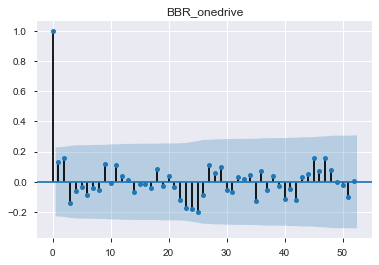

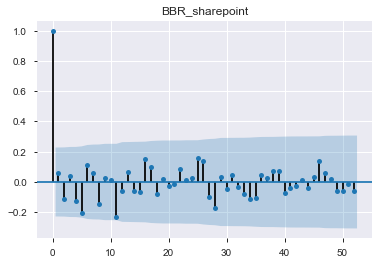

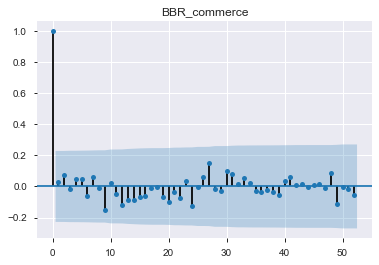

In [103]:
for col in X.columns:
    print(col)
    plot_acf(X[col],lags=52, title=col)

In [104]:
X['NSRlag'] = X['NSR_Overall'].shift(1)
#X['NSRlag2'] = X['NSR'].shift(2)
X['BBRlag'] = X['BBR_Overall'].shift(1)
#X['BBRlag2'] = X['BBR_Overall'].shift(2)

maxlag=1

In [105]:
X_lag = X.iloc[1:,:]
y_lag = y.iloc[1:]

train_test_cutoff = 4*len(y_lag)//5
X_lag_train = X_lag.iloc[:train_test_cutoff]
X_lag_test = X_lag.iloc[train_test_cutoff+1:]
y_lag_train = y_lag.iloc[0:train_test_cutoff]
y_lag_test = y_lag.iloc[train_test_cutoff+1:]

In [106]:
print('AR, MA, Scoring Test Data (Mean Absolute Error)')
for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,1,2,3],
                 [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
    if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
        train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
        model_fit = train_model.fit(disp=0)
        y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
        forecast_error = y_lag_test - y_lag_pred
        mean_absolute_error = np.mean(abs(forecast_error))
        print(ar,ma,round(mean_absolute_error,3))
        #ll = float(model_fit.summary2().tables[0].iloc[1,3])
        #bic = float(model_fit.summary2().tables[0].iloc[0,3])
        #aic = float(model_fit.summary2().tables[0].iloc[8,1])
        #print(ar, ma, ll,bic,aic,round(sum([ll*-1,bic,aic]),1))

AR, MA, Scoring Test Data (Mean Absolute Error)


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 1 3.128


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 2 3.034


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 3 2.912


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1 3.041


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 2 2.987


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 3.059


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 2 3.145


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 3.032


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 2 3.035


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 3 3.148


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 2.847


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 3.477


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 3 2.808


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 3.44


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 2 3.886


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 3 3.622
1 0 3.312
2 0 3.12


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 0 3.116


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Lag 0 and 1 for NSR and BBR:


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   72
Model:                     ARIMA(1, 1, 1)   Log Likelihood                -107.523
Method:                           css-mle   S.D. of innovations              1.043
Date:                    Tue, 03 Mar 2020   AIC                            259.046
Time:                            09:19:54   BIC                            309.132
Sample:                        07-21-2018   HQIC                           278.985
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1920      1.590      0.121      0.904      -2.924       3.308
NSR_Overall                      7.8117      

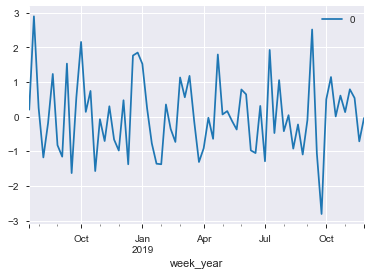

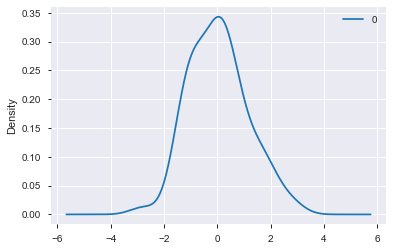

               0
count  72.000000
mean    0.033334
std     1.092588
min    -2.812635
25%    -0.784909
50%    -0.013649
75%     0.615948
max     2.895628


In [107]:
print('Lag 0 and 1 for NSR and BBR:')
model = ARIMA(y_lag, exog=X_lag,order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [108]:
coefficients = model_fit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|t|']<0.1]
coefficients['Coef.']/100

NSR_customer support           -0.035940
NSR_commerce                   -0.025478
BBR_admin                       0.039062
ma.L1.D.Feedback_RatingValue   -0.010000
Name: Coef., dtype: float64

Only lagged variables for NSR and BBR:


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   72
Model:                     ARIMA(1, 1, 1)   Log Likelihood                -108.785
Method:                           css-mle   S.D. of innovations              1.062
Date:                    Tue, 03 Mar 2020   AIC                            257.570
Time:                            09:20:04   BIC                            303.103
Sample:                        07-21-2018   HQIC                           275.696
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.5248      1.416      0.371      0.712      -2.251       3.300
NSR_admin                        1.8703      

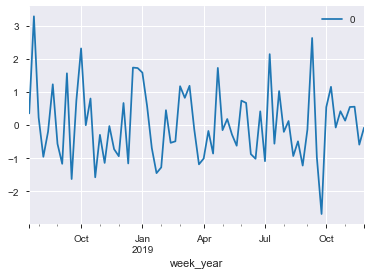

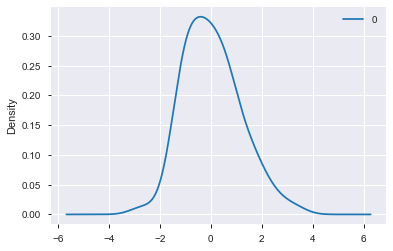

               0
count  72.000000
mean    0.048127
std     1.115841
min    -2.684010
25%    -0.861409
50%    -0.100468
75%     0.689225
max     3.288533


In [109]:
print('Only lagged variables for NSR and BBR:')
model = ARIMA(y_lag, exog=X_lag.drop(columns=['NSR_Overall','BBR_Overall']),order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [110]:
coefficients = model_fit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|t|']<0.1]
coefficients['Coef.']/100

NSR_commerce                   -0.023429
BBR_admin                       0.027200
BBR_outlook                    -0.026676
ma.L1.D.Feedback_RatingValue   -0.010000
Name: Coef., dtype: float64

When Introducing Lag-1 Variables, BBR (Overall appears to be more strongle correlated with changes in NPS than NSR).


Now let's introduce Lags that correspond to a month (Lag-4/5). These lags not only correspond to the lag of a month rather than a week, but they are more appropriate lags to use for model validity when referencing the Autocorrelation Functions.

In [111]:
X['NSRlag'] = X['NSR_Overall'].shift(5)
#X['NSRlag2'] = X['NSR'].shift(2)
X['BBRlag'] = X['BBR_Overall'].shift(4)
#X['BBRlag2'] = X['BBR_Overall'].shift(2)

maxlag=5

X_lag = X.iloc[maxlag:,:]
y_lag = y.iloc[maxlag:]

X.drop(columns=['NSRlag','BBRlag'],inplace=True)

train_test_cutoff = 4*len(y_lag)//5
X_lag_train = X_lag.iloc[:train_test_cutoff]
X_lag_test = X_lag.iloc[train_test_cutoff+1:]
y_lag_train = y_lag.iloc[:train_test_cutoff]
y_lag_test = y_lag.iloc[train_test_cutoff+1:]

In [112]:
print('AR, MA, Scoring Test Data (Mean Absolute Error)')
for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,1,2,3],
                 [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
    if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
        train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
        model_fit = train_model.fit(disp=0)
        y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
        forecast_error = y_lag_test - y_lag_pred
        mean_absolute_error = np.mean(abs(forecast_error))
        print(ar,ma,round(mean_absolute_error,3))
        #ll = float(model_fit.summary2().tables[0].iloc[1,3])
        #bic = float(model_fit.summary2().tables[0].iloc[0,3])
        #aic = float(model_fit.summary2().tables[0].iloc[8,1])
        #print(ar, ma, ll,bic,aic,round(sum([ll*-1,bic,aic]),1))

AR, MA, Scoring Test Data (Mean Absolute Error)


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 1 1.801


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 2 1.399


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 3 3.949


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1 0.834


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 2 2.506


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 2.162


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 2 1.126


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 0.931


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 2 7.523


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 3 3.185


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 6.579


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 6.202


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 3 1.56


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 7.176


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 2 7.303


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 3 6.119
1 0 2.781
2 0 0.992
3 0 1.156


                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   68
Model:                     ARIMA(2, 1, 0)   Log Likelihood                -109.866
Method:                           css-mle   S.D. of innovations              1.209
Date:                    Tue, 03 Mar 2020   AIC                            263.732
Time:                            09:27:22   BIC                            312.562
Sample:                        08-18-2018   HQIC                           283.080
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            3.5434      1.846      1.920      0.061      -0.074       7.161
NSR_Overall                      8.4051      

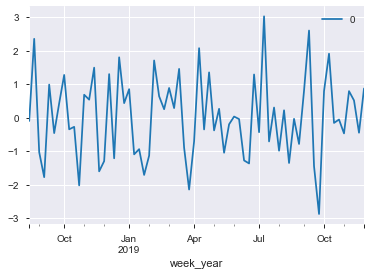

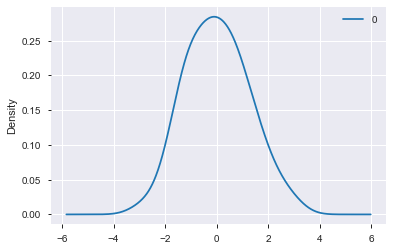

               0
count  68.000000
mean    0.013911
std     1.224819
min    -2.878221
25%    -0.953535
50%    -0.050326
75%     0.814981
max     3.023401


In [113]:
model = ARIMA(y_lag, exog=X_lag,order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [114]:
coefficients = model_fit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|t|']<0.1]
coefficients['Coef.']/100

const                           0.035434
NSR_onedrive                    0.019121
BBR_onedrive                   -0.020325
NSRlag                         -0.025654
ar.L1.D.Feedback_RatingValue   -0.008794
ar.L2.D.Feedback_RatingValue   -0.004351
Name: Coef., dtype: float64

So for longer lags (of a month or so), NSR appears to be stronger sign of future decline than BBR.

In [115]:
import itertools

In [116]:
len(set([1,2,2,2,2,3,4,5]))

5

In [117]:
stuff = [1, 2, 3]
for L in range(1, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        print(subset)

(1,)
(2,)
(3,)
(1, 2)
(1, 3)
(2, 3)
(1, 2, 3)


In [118]:
stuff = list(range(1,5))
for L in range(1, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        print({x:['BBR_Overall','NSR_Overall'] for x in subset})

{1: ['BBR_Overall', 'NSR_Overall']}
{2: ['BBR_Overall', 'NSR_Overall']}
{3: ['BBR_Overall', 'NSR_Overall']}
{4: ['BBR_Overall', 'NSR_Overall']}
{1: ['BBR_Overall', 'NSR_Overall'], 2: ['BBR_Overall', 'NSR_Overall']}
{1: ['BBR_Overall', 'NSR_Overall'], 3: ['BBR_Overall', 'NSR_Overall']}
{1: ['BBR_Overall', 'NSR_Overall'], 4: ['BBR_Overall', 'NSR_Overall']}
{2: ['BBR_Overall', 'NSR_Overall'], 3: ['BBR_Overall', 'NSR_Overall']}
{2: ['BBR_Overall', 'NSR_Overall'], 4: ['BBR_Overall', 'NSR_Overall']}
{3: ['BBR_Overall', 'NSR_Overall'], 4: ['BBR_Overall', 'NSR_Overall']}
{1: ['BBR_Overall', 'NSR_Overall'], 2: ['BBR_Overall', 'NSR_Overall'], 3: ['BBR_Overall', 'NSR_Overall']}
{1: ['BBR_Overall', 'NSR_Overall'], 2: ['BBR_Overall', 'NSR_Overall'], 4: ['BBR_Overall', 'NSR_Overall']}
{1: ['BBR_Overall', 'NSR_Overall'], 3: ['BBR_Overall', 'NSR_Overall'], 4: ['BBR_Overall', 'NSR_Overall']}
{2: ['BBR_Overall', 'NSR_Overall'], 3: ['BBR_Overall', 'NSR_Overall'], 4: ['BBR_Overall', 'NSR_Overall']}
{1: ['

In [119]:
list(range(1,5))

[1, 2, 3, 4]

In [120]:
def lag_features(X,y,feature_lags = {1:['BBR_Overall','NSR_Overall']}):
    
    X_lag = X.copy()
    y_lag = y.copy()
    
    for lag in feature_lags:
        for feat in feature_lags[lag]:
            X_lag[feat+'_lag'+str(lag)] = X_lag[feat].shift(lag)

    lags_used = len(set(feature_lags.keys()))
    minlag=min(feature_lags.keys())
    maxlag=max(feature_lags.keys())
    lagged_features = set()
    for l in feature_lags.values():
        for f in l:
            lagged_features.add(f)
    
    
    X_lag = X_lag.iloc[maxlag:,:]
    y_lag = y_lag.iloc[maxlag:]

    return X_lag, y_lag, list(lagged_features), lags_used, minlag, maxlag

In [288]:
X_lag, y_lag, lagged_features, lags_used, minlag,maxlag = lag_features(X,y,
                                                     {1:['BBR_Overall'],5:['NSR_Overall']})
minlag

dict_keys([1, 5])


1

In [342]:
ts_perf_df = pd.DataFrame(columns=['Lagged_Features','# of Lags','Min Lag','Max Lag',
                                          'AR','MA','MeanAbsError']) #By Sentence, By Not Verbatim

print('AR, MA, Scoring Test Data (Mean Absolute Error)')
training_lags = list(range(1,5))
ID = 0
for L in range(1,len(training_lags)+1):
    for subset in itertools.combinations(training_lags,L):
        input_dict = {x:['NSR_Overall','BBR_Overall'] for x in subset}
        X_lag, y_lag, lagged_features,unique_lags,minlag,maxlag = lag_features(X,y,input_dict)
        train_test_cutoff = 4*len(y_lag)//5
        X_lag_train = X_lag.iloc[:train_test_cutoff]
        X_lag_test = X_lag.iloc[train_test_cutoff+1:]
        y_lag_train = y_lag.iloc[:train_test_cutoff]
        y_lag_test = y_lag.iloc[train_test_cutoff+1:]
        for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,1,2,3],
                         [1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
            if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
                train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
                model_fit = train_model.fit(disp=0)
                y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
                forecast_error = y_lag_test - y_lag_pred
                mean_absolute_error = np.mean(abs(forecast_error))
                #print(ar,ma,round(mean_absolute_error,3))
                ts_perf_df.loc[ID] = [input_dict,unique_lags,minlag,maxlag,ar,ma,mean_absolute_error]
                ID +=1

AR, MA, Scoring Test Data (Mean Absolute Error)
dict_keys([1])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

In [343]:
ts_perf_df[ts_perf_df.MeanAbsError<=1]

,Lagged_Features,# of Lags,Min Lag,Max Lag,AR,MA,MeanAbsError
47,"{4: ['NSR_Overall', 'BBR_Overall']}",1,4,4,2,1,0.893637
48,"{4: ['NSR_Overall', 'BBR_Overall']}",1,4,4,2,2,0.946236


dict_keys([4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   69
Model:                     ARIMA(2, 1, 2)   Log Likelihood                 -98.177
Method:                           css-mle   S.D. of innovations              0.957
Date:                    Wed, 26 Feb 2020   AIC                            244.353
Time:                            22:07:26   BIC                            297.972
Sample:                        08-11-2018   HQIC                           265.625
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            3.2163      1.748      1.840      0.072      -0.210       6.643
NSR_Overall                      7.7086     3

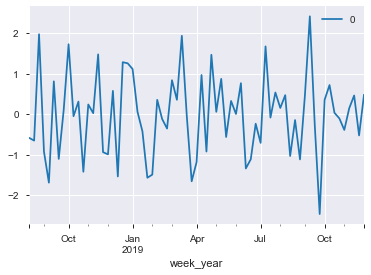

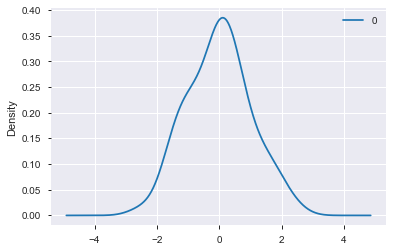

               0
count  69.000000
mean   -0.014423
std     1.009579
min    -2.467528
25%    -0.709923
50%     0.024142
75%     0.535071
max     2.416533


In [339]:
X_lag, y_lag, lagged_features, lags_used, minlag,maxlag = lag_features(X,y,
                                                     {4:['BBR_Overall','NSR_Overall']})
model = ARIMA(y_lag, exog=X_lag,order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [340]:
coefficients = model_fit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|t|']<0.1]
coefficients.round(2)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,3.22,1.75,1.84,0.07,-0.21,6.64
NSR_sharepoint,-0.85,0.47,-1.83,0.07,-1.76,0.06
BBR_onedrive,-2.32,1.13,-2.05,0.05,-4.55,-0.10
NSR_Overall_lag4,-2.55,1.07,-2.39,0.02,-4.63,-0.46
ar.L1.D.Feedback_RatingValue,-1.25,0.14,-9.20,0.00,-1.52,-0.99
ar.L2.D.Feedback_RatingValue,-0.35,0.12,-3.00,0.00,-0.58,-0.12
ma.L2.D.Feedback_RatingValue,-1.00,0.06,-17.74,0.00,-1.11,-0.89


In [344]:
ts_perf_df2 = pd.DataFrame(columns=['Lagged_Features','# of Lags','Min Lag','Max Lag',
                                          'AR','MA','MeanAbsError']) #By Sentence, By Not Verbatim

training_lags = list(range(1,5))
ID = 0
for L in range(1,len(training_lags)+1):
    for subset in itertools.combinations(training_lags,L):
        input_dict = {x:['NSR_Overall','BBR_Overall'] for x in subset}
        X_lag, y_lag, lagged_features,unique_lags,minlag,maxlag = lag_features(X,y,input_dict)
        train_test_cutoff = 4*len(y_lag)//5
        X_lag_train = X_lag.drop(columns=['NSR_Overall',
                                         'BBR_Overall']).iloc[:train_test_cutoff]
        X_lag_test = X_lag.drop(columns=['NSR_Overall',
                                        'BBR_Overall']).iloc[train_test_cutoff+1:]
        y_lag_train = y_lag.iloc[:train_test_cutoff]
        y_lag_test = y_lag.iloc[train_test_cutoff+1:]
        for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,1,2,3],
                         [1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
            if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
                train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
                model_fit = train_model.fit(disp=0)
                y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
                forecast_error = y_lag_test - y_lag_pred
                mean_absolute_error = np.mean(abs(forecast_error))
                #print(ar,ma,round(mean_absolute_error,3))
                ts_perf_df2.loc[ID] = [input_dict,unique_lags,minlag,maxlag,ar,ma,mean_absolute_error]
                ID +=1

dict_keys([1])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

dict_keys([2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

dict_keys([1, 2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

In [345]:
ts_perf_df2[ts_perf_df2.MeanAbsError<=1]

,Lagged_Features,# of Lags,Min Lag,Max Lag,AR,MA,MeanAbsError
90,"{1: ['NSR_Overall', 'BBR_Overall'], 4: ['NSR_O...",2,1,4,1,2,0.940127
98,"{1: ['NSR_Overall', 'BBR_Overall'], 4: ['NSR_O...",2,1,4,2,0,0.949068
99,"{1: ['NSR_Overall', 'BBR_Overall'], 4: ['NSR_O...",2,1,4,3,0,0.936610
133,"{3: ['NSR_Overall', 'BBR_Overall'], 4: ['NSR_O...",2,3,4,1,2,0.902973


In [346]:
all_to_lag = list(X.columns[X.columns.str.startswith('NSR')|X.columns.str.startswith('BBR')])

ts_perf_df3 = pd.DataFrame(columns=['Lagged_Features','# of Lags','Min Lag','Max Lag',
                                          'AR','MA','MeanAbsError']) #By Sentence, By Not Verbatim

training_lags = list(range(1,5))
ID = 0
for L in range(1,len(training_lags)+1):
    for subset in itertools.combinations(training_lags,L):
        input_dict = {x:all_to_lag for x in subset}
        X_lag, y_lag, lagged_features,unique_lags,minlag,maxlag = lag_features(X,y,input_dict)
        train_test_cutoff = 4*len(y_lag)//5
        X_lag_train = X_lag.iloc[:train_test_cutoff]
        X_lag_test = X_lag.iloc[train_test_cutoff+1:]
        y_lag_train = y_lag.iloc[:train_test_cutoff]
        y_lag_test = y_lag.iloc[train_test_cutoff+1:]
        for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,1,2,3],
                         [1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
            if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
                train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
                model_fit = train_model.fit(disp=0)
                y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
                forecast_error = y_lag_test - y_lag_pred
                mean_absolute_error = np.mean(abs(forecast_error))
                #print(ar,ma,round(mean_absolute_error,3))
                ts_perf_df3.loc[ID] = [input_dict,unique_lags,minlag,maxlag,ar,ma,mean_absolute_error]
                ID +=1

dict_keys([1])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([1, 2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 2, 3])
dict_keys([1, 2, 4])
dict_keys([1, 3, 4])
dict_keys([2, 3, 4])
dict_keys([1, 2, 3, 4])


In [347]:
ts_perf_df3[ts_perf_df3.MeanAbsError==ts_perf_df3.MeanAbsError.min()]

,Lagged_Features,# of Lags,Min Lag,Max Lag,AR,MA,MeanAbsError
14,"{2: ['NSR_Overall', 'NSR_admin', 'NSR_customer...",1,2,2,0,3,2.271483


In [348]:
ts_perf_df4 = pd.DataFrame(columns=['Lagged_Features','# of Lags','Min Lag','Max Lag',
                                          'AR','MA','MeanAbsError']) #By Sentence, By Not Verbatim

training_lags = list(range(1,5))
ID = 0
for L in range(1,len(training_lags)+1):
    for subset in itertools.combinations(training_lags,L):
        input_dict = {x:all_to_lag for x in subset}
        X_lag, y_lag, lagged_features,unique_lags,minlag,maxlag = lag_features(X,y,input_dict)
        train_test_cutoff = 4*len(y_lag)//5
        X_lag_train = X_lag.drop(columns=all_to_lag).iloc[:train_test_cutoff]
        X_lag_test = X_lag.drop(columns=all_to_lag).iloc[train_test_cutoff+1:]
        y_lag_train = y_lag.iloc[:train_test_cutoff]
        y_lag_test = y_lag.iloc[train_test_cutoff+1:]
        for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,1,2,3],
                         [1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
            if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
                train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
                model_fit = train_model.fit(disp=0)
                y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
                forecast_error = y_lag_test - y_lag_pred
                mean_absolute_error = np.mean(abs(forecast_error))
                #print(ar,ma,round(mean_absolute_error,3))
                ts_perf_df4.loc[ID] = [input_dict,unique_lags,minlag,maxlag,ar,ma,mean_absolute_error]
                ID +=1

dict_keys([1])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

dict_keys([2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

dict_keys([3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

dict_keys([4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

dict_keys([1, 2])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

dict_keys([2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 2, 3])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 2, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([2, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mode

dict_keys([1, 2, 3, 4])


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [363]:
ts_perf_df4[ts_perf_df4.MeanAbsError==ts_perf_df4.MeanAbsError.min()].Lagged_Features.values

array([{2: ['NSR_Overall', 'NSR_admin', 'NSR_customer support', 'NSR_outlook', 'NSR_marketing', 'NSR_onedrive', 'NSR_sharepoint', 'NSR_commerce', 'BBR_Overall', 'BBR_admin', 'BBR_customer support', 'BBR_outlook', 'BBR_marketing', 'BBR_onedrive', 'BBR_sharepoint', 'BBR_commerce']}],
      dtype=object)

In [313]:
# for N in range(1,len(all_to_lag)+1):
#     for combo in itertools.combinations(all_to_lag,N):
#         print(combo)

In [121]:
all_to_lag = list(X.columns[X.columns.str.startswith('NSR')|X.columns.str.startswith('BBR')])

In [ ]:
ts_perf_df5 = pd.DataFrame(columns=['Lagged_Features','# of Lags','Min Lag','Max Lag',
                                          'AR','MA','MeanAbsError']) #By Sentence, By Not Verbatim

training_lags = list(range(1,5))
ID = 0
for N in range(1,len(all_to_lag)+1):
    for combo in itertools.combinations(all_to_lag,N):
        for L in range(1,len(training_lags)+1):
            for subset in itertools.combinations(training_lags,L):
                input_dict = {x:list(combo) for x in subset}
                X_lag, y_lag, lagged_features,unique_lags,minlag,maxlag = lag_features(X,y,input_dict)
                train_test_cutoff = 4*len(y_lag)//5
                X_lag_train = X_lag.iloc[:train_test_cutoff]
                X_lag_test = X_lag.iloc[train_test_cutoff+1:]
                y_lag_train = y_lag.iloc[:train_test_cutoff]
                y_lag_test = y_lag.iloc[train_test_cutoff+1:]
                for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,1,2,3],
                                 [1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
                    if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
                        train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
                        model_fit = train_model.fit(disp=0)
                        y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
                        forecast_error = y_lag_test - y_lag_pred
                        mean_absolute_error = np.mean(abs(forecast_error))
                        #print(ar,ma,round(mean_absolute_error,3))
                        ts_perf_df5.loc[ID] = [input_dict,unique_lags,minlag,maxlag,ar,ma,mean_absolute_error]
                        ID +=1

C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages

In [ ]:
ts_perf_df5[ts_perf_df5.MeanAbsError<0.9]

In [ ]:
ts_perf_df5.Lagged_Features.value_counts()

In [ ]:
ts_perf_df6 = pd.DataFrame(columns=['Lagged_Features','# of Lags','Min Lag','Max Lag',
                                          'AR','MA','MeanAbsError']) #By Sentence, By Not Verbatim

training_lags = list(range(1,5))
ID = 0
for N in range(1,len(all_to_lag)+1):
    for combo in itertools.combinations(all_to_lag,N):
        for L in range(1,len(training_lags)+1):
            for subset in itertools.combinations(training_lags,L):
                input_dict = {x:list(combo) for x in subset}
                X_lag, y_lag, lagged_features,unique_lags,minlag,maxlag = lag_features(X,y,input_dict)
                train_test_cutoff = 4*len(y_lag)//5
                X_lag_train = X_lag.drop(columns=all_to_lag).iloc[:train_test_cutoff]
                X_lag_test = X_lag.drop(columns=columnsto_lag).iloc[train_test_cutoff+1:]
                y_lag_train = y_lag.iloc[:train_test_cutoff]
                y_lag_test = y_lag.iloc[train_test_cutoff+1:]
                for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,1,2,3],
                                 [1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
                    if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
                        train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
                        model_fit = train_model.fit(disp=0)
                        y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
                        forecast_error = y_lag_test - y_lag_pred
                        mean_absolute_error = np.mean(abs(forecast_error))
                        print(ar,ma,round(mean_absolute_error,3))
                        ts_perf_df6.loc[ID] = [input_dict,unique_lags,minlag,maxlag,ar,ma,mean_absolute_error]
                        ID +=1

In [ ]:
ts_perf_df6[ts_perf_df6.MeanAbsError<=1]

In [159]:
print('AR, MA, Scoring Test Data (Mean Absolute Error)')
for ar,ma in zip([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,1,2,3],
                 [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,0,0]):
    if make_arimaCovar(y_lag_train,X_lag_train,ar,ma):
        train_model = ARIMA(y_lag_train, exog=X_lag_train,order=(ar,1,ma))
        model_fit = train_model.fit(disp=0)
        y_lag_pred = model_fit.forecast(steps=len(X_lag_test),exog=X_lag_test)[0] 
        forecast_error = y_lag_test - y_lag_pred
        mean_absolute_error = np.mean(abs(forecast_error))
        print(ar,ma,round(mean_absolute_error,3))
        #ll = float(model_fit.summary2().tables[0].iloc[1,3])
        #bic = float(model_fit.summary2().tables[0].iloc[0,3])
        #aic = float(model_fit.summary2().tables[0].iloc[8,1])
        #print(ar, ma, ll,bic,aic,round(sum([ll*-1,bic,aic]),1))

AR, MA, Scoring Test Data (Mean Absolute Error)


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 1 2.42


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 2 3.278


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 3 3.055


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 1 2.447


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 2 2.879


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 2.652


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 2 2.742


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 3 2.678


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 3.012


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 2 2.977


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 3 2.996


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 1 2.564


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 2 3.105


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 3 3.013


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 1 2.978


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 2 3.046


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 3 3.315
1 0 2.152
2 0 2.172


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 0 2.22


C:\Users\v-Jaand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
best_models = pd.concat([x[x.MeanAbsError==x.MeanAbsError.min()] for x in [ts_perf_df,ts_perf_df2,
                                                                           ts_perf_df3,ts_perf_df4,
                                                                           ts_perf_df5,ts_perf_df6]]

FINAL MODEL
                               ARIMA Model Results                                
Dep. Variable:     D.Feedback_RatingValue   No. Observations:                   68
Model:                     ARIMA(3, 1, 3)   Log Likelihood                 -98.710
Method:                           css-mle   S.D. of innovations              0.977
Date:                    Fri, 24 Jan 2020   AIC                            235.421
Time:                            14:48:28   BIC                            277.591
Sample:                        08-18-2018   HQIC                           252.130
                             - 11-30-2019                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.8176      1.249      1.455      0.152      -0.631       4.266
NSR                              

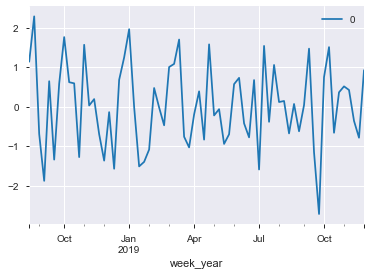

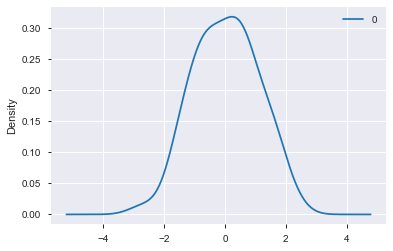

               0
count  68.000000
mean    0.031253
std     1.053594
min    -2.713888
25%    -0.712428
50%     0.035855
75%     0.691721
max     2.285595


In [643]:
print('FINAL MODEL') #(3,1,3)
model = ARIMA(y_lag, exog=X_lag,order=(3,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [645]:
coefficients = model_fit.summary2().tables[1]
coefficients = coefficients[coefficients['P>|t|']<0.1]
coefficients.round(2)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
NSR,2.18,0.68,3.23,0.00,0.86,3.51
BBR_Overall,-7.51,2.83,-2.65,0.01,-13.05,-1.96
BBR_Admin,1.85,0.83,2.24,0.03,0.23,3.47
BBR_OneDrive,-0.93,0.39,-2.38,0.02,-1.69,-0.16
BBR_Commerce,-1.67,0.85,-1.96,0.06,-3.33,0.00
BBR_Overall_lag1,8.30,2.63,3.15,0.00,3.14,13.46
NSR_lag5,-2.00,0.62,-3.25,0.00,-3.21,-0.79
ar.L1.D.Feedback_RatingValue,-0.98,0.16,-6.32,0.00,-1.29,-0.68
ar.L2.D.Feedback_RatingValue,-1.00,0.16,-6.44,0.00,-1.31,-0.70
ma.L1.D.Feedback_RatingValue,-0.17,0.08,-2.30,0.03,-0.32,-0.03


# Results/Findings So Far:

## Verbatim Level Modeling
* Verbatim Feedacks can be near-evenly clustered into 5/5, 1/5, and 2-4/5
* Shorter verbatims are associated with higher NPS. 
* Longer verbatims tend to have higher NSR, which is associated with lower NPS.

## Sentence Level Modeling
* Joint Distributions of Feedback Rating and Sentiment Per Sentence Topic is strongly skewed towards Negative and even just 1/5 ratings. 
 * Especially for Commerce
* ML Classification of Sentences tends to be very low or very high - not many neutrals to work with when using 3 classes. A percentage point increase in Classification Probability is positvely is associated with higher NPS.
* Sentences about Admin, Customer Support, Commerce, Outlook, Sharepoint associated with lower NPS, while sentences about Marketing associated with higher NPS.

## Time Series Analysis
* Autoregressor and Moving Average variables are useful in modeling weekly NPS alongside covariates.
* NSR and Overall BBR have different lags that are useful for modeling correlation with weekly NPS. 
 * NSR: Month Lag (negative relationship)
 * BBR: Week Lag (positive Relationship)
* Theme-level BBR for Admin(+), Onedrive(-), and Commerce(-) also have correlations with weekly NPS within the same timeframe (i.e. correlation is not lagged)